# BFuzzer

Some magick before we get started.
* %top and %%top are magicks for line and cell respectively that can be used to disable the evaluation when the notebook is exported.
* %%var is used to extract contents of the cell to `$VARS` variable.

In [1]:
TOP = True

In [2]:
from IPython.core.magic import  (Magics, magics_class, cell_magic, line_magic, line_cell_magic)
class B(dict):
    def __getattr__(self, name):
        return self.__getitem__(name)
@magics_class
class MyMagics(Magics):
    def __init__(self, shell=None,  **kwargs):
        super().__init__(shell=shell, **kwargs)
        self._vars = B()
        shell.user_ns['VARS'] = self._vars

    @cell_magic
    def var(self, line, cell):
        self._vars[line.strip()] = cell.strip()
 
    @line_cell_magic
    def top(self, line, cell=None):
        if TOP:
            if cell is None:
                cell = line
            ip = get_ipython()
            res = ip.run_cell(cell)

get_ipython().register_magics(MyMagics)

This notebook has only been tested in the specific Python versions below.

In [3]:
import sys

In [4]:
%top assert sys.version_info[0:2] in [(3, 6)]

Jupyter has the bad habit of continuing the execution sometimes after an exception has happened. This variable tells us if any exception has happened until now.

In [5]:
EXCEPTION_HAPPENED = []

In [6]:
%top IP = get_ipython()

In [7]:
from IPython.core.ultratb import AutoFormattedTB
itb = AutoFormattedTB(mode = 'Plain', tb_offset = 1)
def custom_exc(shell, etype, evalue, tb, tb_offset=None):
    global EXCEPTION_HAPPENED
    EXCEPTION_HAPPENED.append(IP.last_execution_result.execution_count + 1)
    shell.showtraceback((etype, evalue, tb), tb_offset=tb_offset)

In [8]:
%top IP.set_custom_exc((Exception,), custom_exc)

## Do

Next, we define a wrapper for command execution.

In [9]:
import subprocess
import os
import json

The `do()` command executes and saves return code, stdin and stderr.

In [10]:
class O:
    def __init__(self, **keys): self.__dict__.update(keys)
    def __repr__(self): return str(self.__dict__)

In [11]:
def do(command, env=None, shell=False, log=False, **args):
    result = subprocess.Popen(command, stdout=subprocess.PIPE, stderr = subprocess.PIPE,
                              shell=shell,
                              env=dict(os.environ, **({} if env is None else env))
                             )
    stdout, stderr = result.communicate(timeout=10)
    os.makedirs('build', exist_ok=True)
    code = result.returncode
    ecode = ((256-code) * -1) if code > 127 else code
    if log:
        with open('build/do.log', 'a+') as f:
            print(json.dumps({'cmd':command, 'env':env, 'exitcode':ecode, 'ocode':code}), env, file=f)
    return O(cmd=command,returncode=ecode, ocode=result.returncode, stdout=stdout, stderr=stderr)

#### Extract Status

In [32]:
def logit(v):
    print(v, file=sys.stderr)

In [33]:
import random

In [34]:
random.seed(0) # Note: Seed is not useful in experiments since we rely also on time.

# Experiments

First, we regenrate the data files for `pFuzzer`.

In [131]:
!make pFuzz

/Library/Developer/CommandLineTools/usr/bin/make clean
find . -name __pycache__ -type d -print0 -prune | xargs -0 -- rm -r
for i in examples/cjson/ examples/csv/ examples/ini/ examples/mjs/ examples/tiny/; do (cd $i; make clean); done
rm -rf *.o cjson __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
rm -rf *.o csvparser __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
rm -rf *.o ini __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
rm -rf *.o mjs __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
rm -rf *.o tiny __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
rm -rf examples/results_*.json
/Library/Developer/CommandLineTools/usr/bin/make compile
for i in examples/cjson/ examples/csv/ examples/ini/ examples/mjs/ examples/tiny/; do (cd $i; make); done
gcc -g -o cjson cJSON.c
cJSON.c:102:23: warning: passing 'const unsigned char *' to parameter of type
      'const char *' converts between pointers to integer types with different
      sign [-Wpointer-sign]
  string_len = strlen(string1);
           

10 warnings generated.
gcc -g -o csvparser csvparser.c
gcc -fprofile-arcs -ftest-coverage -g -o csvparser.cov csvparser.c
gcc -g -o ini ini.c
gcc -fprofile-arcs -ftest-coverage -g -o ini.cov ini.c
gcc -ldl -g -o mjs mjs.c
gcc -ldl -fprofile-arcs -ftest-coverage -g -o mjs.cov mjs.c
gcc -g -o tiny tiny.c
tiny.c:105:49: warning: add explicit braces to avoid dangling else
      [-Wdangling-else]
              if (id_name[1] == '\0') sym = ID; else syntax_error();
                                                ^
1 warning generated.
gcc -fprofile-arcs -ftest-coverage -g -o tiny.cov tiny.c
tiny.c:105:49: warning: add explicit braces to avoid dangling else
      [-Wdangling-else]
              if (id_name[1] == '\0') sym = ID; else syntax_error();
                                                ^
1 warning generated.
/Library/Developer/CommandLineTools/usr/bin/make convert
cd pfuzzer/; for i in *.txt; do \
		echo ../convert_validtxt.py $i  ${i//.txt/.py}; \
		python3 ../convert_validtxt.py $

In [132]:
!tail -1 pfuzzer/results_*

==> pfuzzer/results_cjson.json <==
{"output": [32, 123, 34, 34, 58, 91, 51, 46, 48, 69, 50, 53, 93, 125], "cumcoverage": ["14.78", "14.76"], "time": 1281.298261}

==> pfuzzer/results_csvparser.json <==
{"output": [53, 72, 10, 44, 10, 34, 34, 53, 13], "cumcoverage": ["66.97", "58.33"], "time": 341.74004}

==> pfuzzer/results_ini.json <==
{"output": [32, 10, 61], "cumcoverage": ["76.15", "58.97"], "time": 2503.109502}

==> pfuzzer/results_mjs.json <==
{"output": [82, 38, 40, 43, 34, 34, 47, 39, 72, 39, 62, 40, 53, 94, 45, 45, 52, 46, 53, 101, 50, 41, 41], "cumcoverage": ["21.18", "11.96"], "time": 2023.479886}

==> pfuzzer/results_tiny.json <==
{"output": [32, 10, 105, 102, 32, 40, 53, 41, 59], "cumcoverage": ["87.82", "73.23"], "time": 1015.704999}


Now, we are ready to do the bFuzzer experiments.

In [133]:
from datetime import datetime

In [134]:
from IPython.display import Image

In [135]:
from io import BytesIO

In [136]:
def zoom(v, fname=None):
    # return v directly if you do not want to zoom out.
    assert v is not None
    if zoom:
        figfile = BytesIO()
        v.savefig(figfile, format='svg')
        Image(figfile.getvalue())
        if fname is None: fname = 'myfile'
        with open('%s.svg' % fname, 'wb+') as f:
            f.write(figfile.getvalue())
        return 
    return v

In [140]:
import time
from datetime import timedelta, datetime

In [142]:
time_to_run = 3600

## TinyC

In [143]:
def logit(v):
    ...

In [146]:
!wc -l build/results_tinyc.json

     505 build/results_tinyc.json


In [147]:
!tail build/results_tinyc.json

{"output": [109, 10, 61, 117, 32, 61, 50, 10, 43, 103, 45, 97, 43, 100, 10, 10, 32, 10, 10, 32, 32, 10, 45, 54, 43, 54, 57, 50, 10, 10, 10, 43, 56, 10, 45, 55, 59], "cumcoverage": ["83.44", "71.65"], "time": 3503.858699798584}
{"output": [99, 59, 32, 32, 10, 10], "cumcoverage": ["83.44", "71.65"], "time": 3508.006595849991}
{"output": [32, 54, 32, 32, 43, 97, 10, 59], "cumcoverage": ["83.44", "71.65"], "time": 3510.056427717209}
{"output": [117, 60, 105, 45, 10, 10, 100, 59], "cumcoverage": ["83.44", "71.65"], "time": 3513.218380689621}
{"output": [55, 57, 59, 32, 32, 10], "cumcoverage": ["83.44", "71.65"], "time": 3515.815191745758}
{"output": [123, 53, 55, 49, 54, 49, 60, 97, 10, 10, 43, 114, 32, 32, 43, 115, 45, 49, 45, 57, 49, 57, 32, 45, 112, 10, 43, 10, 119, 45, 52, 49, 48, 54, 59, 106, 43, 122, 43, 48, 32, 59, 52, 57, 43, 100, 59, 104, 10, 59, 121, 45, 51, 45, 103, 32, 43, 50, 10, 45, 54, 56, 56, 53, 54, 51, 45, 55, 53, 43, 10, 51, 43, 115, 32, 60, 104, 32, 45, 118, 10, 45, 110,

## Ini

In [150]:
!wc -l build/results_ini.json

     183 build/results_ini.json


In [151]:
!tail build/results_ini.json

{"output": [175, 133, 150, 146, 159, 143, 217, 57, 144, 38, 216, 247, 197, 192, 170, 116, 59, 206, 187, 99, 75, 103, 208, 183, 161, 166, 116, 243, 166, 157, 242, 213, 55, 240, 222, 228, 31, 132, 217, 70, 87, 119, 198, 67, 51, 219, 46, 235, 127, 15, 214, 236, 202, 9, 70, 126, 228, 206, 198, 78, 145, 179, 251, 146, 182, 86, 3, 55, 7, 161, 127, 25, 238, 44, 241, 238, 243, 94, 8, 183, 142, 11, 48, 232, 139, 8, 153, 131, 128, 13, 49, 101, 4, 152, 65, 248, 26, 197, 13, 254, 61], "cumcoverage": ["75.38", "57.69"], "time": 3392.6332290172577}
{"output": [163, 58, 94, 83, 200], "cumcoverage": ["75.38", "57.69"], "time": 3392.730494260788}
{"output": [153, 229, 120, 175, 170, 27, 22, 84, 115, 6, 46, 118, 223, 120, 216, 155, 180, 68, 127, 21, 110, 49, 216, 204, 185, 102, 96, 12, 98, 180, 138, 237, 5, 53, 22, 181, 93, 37, 110, 89, 120, 92, 211, 227, 116, 5, 112, 131, 132, 164, 155, 248, 173, 37, 217, 72, 74, 167, 166, 216, 7, 145, 183, 190, 35, 207, 6, 61, 196], "cumcoverage": ["75.38", "57.69"], 

## CSV

In [154]:
!wc -l build/results_csv.json

   33528 build/results_csv.json


In [155]:
!tail build/results_csv.json

{"output": [174, 67, 156, 69], "cumcoverage": ["66.97", "58.33"], "time": 3599.1013588905334}
{"output": [207, 136, 116, 151, 164], "cumcoverage": ["66.97", "58.33"], "time": 3599.19219994545}
{"output": [168, 210, 58, 42, 111, 144, 125], "cumcoverage": ["66.97", "58.33"], "time": 3599.301171064377}
{"output": [4, 141, 138, 142, 29, 234, 132], "cumcoverage": ["66.97", "58.33"], "time": 3599.449692964554}
{"output": [103, 175, 46, 234], "cumcoverage": ["66.97", "58.33"], "time": 3599.529397010803}
{"output": [76, 170, 244, 244], "cumcoverage": ["66.97", "58.33"], "time": 3599.6209280490875}
{"output": [210, 203, 249, 52], "cumcoverage": ["66.97", "58.33"], "time": 3599.704938173294}
{"output": [136, 58, 10, 21, 56, 40], "cumcoverage": ["66.97", "58.33"], "time": 3599.804256916046}
{"output": [113, 132, 75, 40], "cumcoverage": ["66.97", "58.33"], "time": 3599.8992841243744}
{"output": [241, 117, 18, 167], "cumcoverage": ["66.97", "58.33"], "time": 3600.0225481987}


## MJS

In [158]:
!wc -l build/results_mjs.json

    1417 build/results_mjs.json


In [159]:
!tail build/results_mjs.json

{"output": [114, 39, 218, 30, 254, 111], "cumcoverage": ["25.99", "17.37"], "time": 3557.4555599689484}
{"output": [83, 89, 54, 53, 75, 12, 115], "cumcoverage": ["25.99", "17.37"], "time": 3557.808247089386}
{"output": [86, 122, 119], "cumcoverage": ["25.99", "17.37"], "time": 3569.263290166855}
{"output": [71, 122, 37, 51, 77, 13], "cumcoverage": ["25.99", "17.37"], "time": 3569.436159133911}
{"output": [50, 11, 109, 121], "cumcoverage": ["25.99", "17.37"], "time": 3569.672958135605}
{"output": [118, 72, 61, 49, 43, 115], "cumcoverage": ["25.99", "17.37"], "time": 3569.999044895172}
{"output": [104, 115, 106, 50, 75], "cumcoverage": ["25.99", "17.37"], "time": 3570.1326401233673}
{"output": [86, 97, 56, 45, 102, 101, 110], "cumcoverage": ["25.99", "17.37"], "time": 3570.2902841567993}
{"output": [54], "cumcoverage": ["25.99", "17.37"], "time": 3586.4174950122833}
{"output": [102], "cumcoverage": ["25.99", "17.37"], "time": 3600.265790939331}


## CJSON

In [162]:
!wc -l build/results_cjson.json

     403 build/results_cjson.json


In [163]:
!tail build/results_cjson.json

{"output": [21, 7, 49, 92], "cumcoverage": ["12.40", "11.54"], "time": 3552.505758047104}
{"output": [54, 218, 180, 86], "cumcoverage": ["12.40", "11.54"], "time": 3552.668755054474}
{"output": [25, 54, 6, 242, 132], "cumcoverage": ["12.40", "11.54"], "time": 3552.8040850162506}
{"output": [13, 1, 49, 32], "cumcoverage": ["12.40", "11.54"], "time": 3553.050775051117}
{"output": [11, 15, 7, 52], "cumcoverage": ["12.40", "11.54"], "time": 3553.38756108284}
{"output": [3, 9, 9, 30, 17, 26, 20, 32, 20, 28, 19, 3, 10, 51, 23, 47], "cumcoverage": ["12.40", "11.54"], "time": 3568.171782016754}
{"output": [52, 225, 37, 36, 20, 131, 137], "cumcoverage": ["12.40", "11.54"], "time": 3568.326775789261}
{"output": [56, 102, 135, 77, 56, 206], "cumcoverage": ["12.40", "11.54"], "time": 3568.4631309509277}
{"output": [9, 26, 21, 19, 15, 54], "cumcoverage": ["12.40", "11.54"], "time": 3568.8934967517853}
{"output": [7, 26, 19, 24, 1, 20, 52, 221, 205, 40], "cumcoverage": ["12.40", "11.54"], "time": 35

## Final

In [164]:
import matplotlib.pyplot as plt

In [165]:
def read_cov_data(file_name):
    line_a, branch_a, ct_a, o_a = [], [], [], []
    with open(file_name) as f:
        while True:
            v = f.readline()
            if v is None: break
            if not v: break
            r = json.loads(v)
            line, branch =  [float(i) for i in r['cumcoverage']]
            ct = r['time']
            o = bytes(r['output'])
            line_a.append(line)
            branch_a.append(branch)
            ct_a.append(ct)
            o_a.append(o)
            if ct > 3600: break # maximum 1 hr.
    # make sure we have a continuous line (because cumulative.)
    line_a.append(line_a[-1])
    branch_a.append(branch_a[-1])
    ct_a.append(3600)
    o_a.append(None)
    print(ct_a[-1], ' line:', line_a[-1], 'branch: ', branch_a[-1])
    return o_a, ct_a, line_a, branch_a

In [166]:
from IPython.display import HTML, display

In [167]:
def show_table(keys, autogram, mimid, title, fn):
    keys = [k for k in keys if k in autogram and k in mimid and autogram[k] and mimid[k]]
    tbl = ['<tr>%s</tr>' % ''.join(["<th>%s</th>" % k for k in ['<b>%s</b>' % title,'Autogram', 'Mimid']])]
    for k in keys:
        h_c = "<td>%s</td>" % k
        a_c = "<td>%s</td>" % fn(autogram.get(k,('',0)))
        m_c = "<td>%s</td>" % fn(mimid.get(k,('',0)))
        tbl.append('<tr>%s</tr>' % ''.join([h_c, a_c, m_c]))
    return display(HTML('<table>%s</table>' % '\n'.join(tbl)))

In [168]:
def to_sec(hm):
    return {k:((hm[k][1]).seconds, 1) for k in hm if hm[k]}

In [169]:
import statistics

In [170]:
def stats(lst_):
    # remove last
    assert lst_[-1] is None
    lst = lst_[0:-1]
    uniql = list({str(l) for l in lst})
    print('Total: ', len(lst))
    print('Unique: ', len(uniql))
    print('MaxLen: ', max([len(l) for l in uniql]))
    print('MinLen: ', min([len(l) for l in uniql]))
    print('Mean: ', statistics.mean([len(l) for l in uniql]))

### TinyC

In [171]:
len(tinyc_lst)

497

In [172]:
tinyc_outputs, tinyc_time, tinyc_line, tinyc_branch = read_cov_data('build/results_tinyc.json')

3600  line: 83.44 branch:  71.65


In [173]:
stats(tinyc_outputs)

Total:  505
Unique:  497
MaxLen:  464
MinLen:  7
Mean:  20.603621730382294


In [174]:
ptinyc_outputs, ptinyc_time, ptinyc_line, ptinyc_branch = read_cov_data('pfuzzer/results_tiny.json')

3600  line: 87.82 branch:  73.23


In [175]:
stats(ptinyc_outputs)

Total:  9
Unique:  9
MaxLen:  16
MinLen:  5
Mean:  10.222222222222221


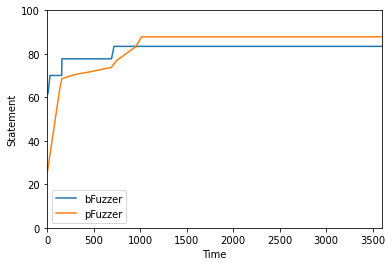

In [176]:
plt.plot(tinyc_time, tinyc_line, label='bFuzzer')
plt.plot(ptinyc_time, ptinyc_line, label='pFuzzer')
plt.ylabel('Statement')
plt.xlabel('Time')
#plt.title('TinyC Cumulative Statement Coverage')
plt.axis([0, 3600, 0, 100]) 
plt.legend()
zoom(plt, 'tinyc-s')

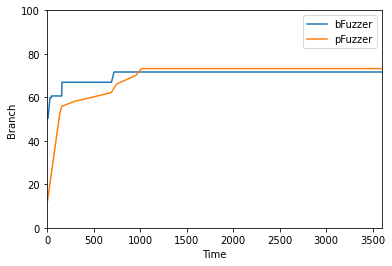

In [177]:
plt.plot(tinyc_time, tinyc_branch, label='bFuzzer')
plt.plot(ptinyc_time, ptinyc_branch, label='pFuzzer')
plt.ylabel('Branch')
plt.xlabel('Time')
#plt.title('TinyC Cumulative Branch Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
zoom(plt, 'tinyc-b')

### Ini

In [178]:
len(ini_lst)

177

In [179]:
ini_outputs, ini_time, ini_line, ini_branch = read_cov_data('build/results_ini.json')

3600  line: 75.38 branch:  57.69


In [180]:
stats(ini_outputs)

Total:  183
Unique:  177
MaxLen:  520
MinLen:  4
Mean:  133.71186440677965


In [181]:
pini_outputs, pini_time, pini_line, pini_branch = read_cov_data('pfuzzer/results_ini.json')

3600  line: 76.15 branch:  58.97


In [182]:
stats(pini_outputs)

Total:  8
Unique:  8
MaxLen:  7
MinLen:  4
Mean:  5


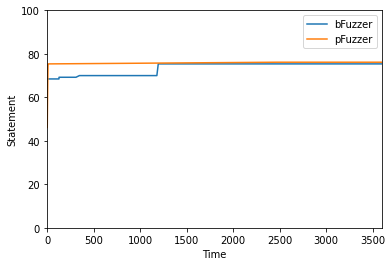

In [183]:
plt.plot(ini_time, ini_line, label='bFuzzer')
plt.plot(pini_time, pini_line, label='pFuzzer')
plt.ylabel('Statement')
plt.xlabel('Time')
#plt.title('INI Cumulative Statement Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
zoom(plt, 'ini-s')

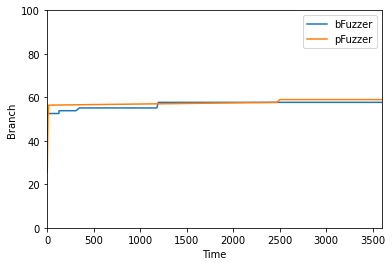

In [184]:
plt.plot(ini_time, ini_branch, label='bFuzzer')
plt.plot(pini_time, pini_branch, label='pFuzzer')
plt.ylabel('Branch')
plt.xlabel('Time')
#plt.title('INI Cumulative Branch Coverage')
plt.axis([0, 3600, 0, 100]) 
plt.legend()
zoom(plt, 'ini-b')

### CSV

In [185]:
len(csv_lst)

33528

In [186]:
csv_outputs, csv_time, csv_line, csv_branch = read_cov_data('build/results_csv.json')

3600  line: 66.97 branch:  58.33


In [187]:
stats(csv_outputs)

Total:  33528
Unique:  33528
MaxLen:  43
MinLen:  7
Mean:  16.98914340252923


In [188]:
pcsv_outputs, pcsv_time, pcsv_line, pcsv_branch = read_cov_data('pfuzzer/results_csvparser.json')

3600  line: 66.97 branch:  58.33


In [189]:
stats(pcsv_outputs)

Total:  9
Unique:  9
MaxLen:  15
MinLen:  4
Mean:  6.666666666666667


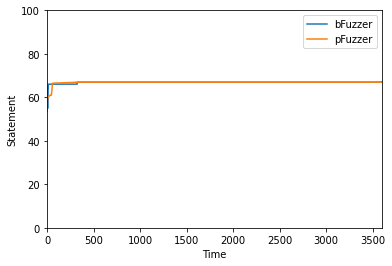

In [190]:
plt.plot(csv_time, csv_line, label='bFuzzer')
plt.plot(pcsv_time, pcsv_line, label='pFuzzer')
plt.ylabel('Statement')
plt.xlabel('Time')
#plt.title('CSV Cumulative Statement Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
zoom(plt, 'csv-s')

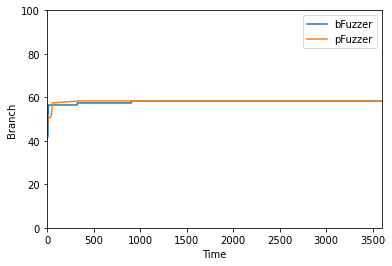

In [191]:
plt.plot(csv_time, csv_branch, label='bFuzzer')
plt.plot(pcsv_time, pcsv_branch, label='pFuzzer')
plt.ylabel('Branch')
plt.xlabel('Time')
#plt.title('CSV Cumulative Branch Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
zoom(plt, 'csv-b')

### MJS

In [192]:
len(mjs_lst)

1398

In [193]:
mjs_outputs, mjs_time, mjs_line, mjs_branch = read_cov_data('build/results_mjs.json')

3600  line: 25.99 branch:  17.37


In [194]:
stats(mjs_outputs)

Total:  1417
Unique:  1398
MaxLen:  102
MinLen:  4
Mean:  9.46065808297568


In [195]:
pmjs_outputs, pmjs_time, pmjs_line, pmjs_branch = read_cov_data('pfuzzer/results_mjs.json')

3600  line: 21.18 branch:  11.96


In [196]:
stats(pmjs_outputs)

Total:  16
Unique:  16
MaxLen:  28
MinLen:  4
Mean:  7


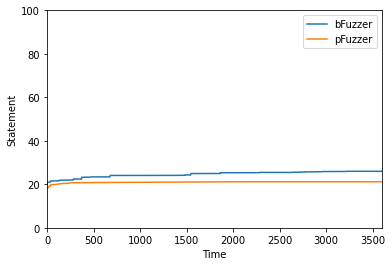

In [197]:
plt.plot(mjs_time, mjs_line, label='bFuzzer')
plt.plot(pmjs_time, pmjs_line, label='pFuzzer')
plt.ylabel('Statement')
plt.xlabel('Time')
#plt.title('MJS Cumulative Statement Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
zoom(plt, 'mjs-s')

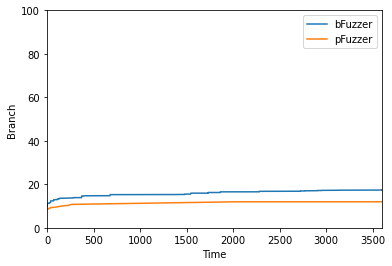

In [198]:
plt.plot(mjs_time, mjs_branch, label='bFuzzer')
plt.plot(pmjs_time, pmjs_branch, label='pFuzzer')
plt.ylabel('Branch')
plt.xlabel('Time')
#plt.title('MJS Cumulative Branch Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
zoom(plt, 'mjs-b')

### CJSON

In [199]:
len(cjson_lst)

403

In [200]:
cjson_outputs, cjson_time, cjson_line, cjson_branch = read_cov_data('build/results_cjson.json')

3600  line: 12.4 branch:  11.54


In [201]:
stats(cjson_outputs)

Total:  403
Unique:  403
MaxLen:  435
MinLen:  7
Mean:  23.622828784119108


In [202]:
pcjson_outputs, pcjson_time, pcjson_line, pcjson_branch = read_cov_data('pfuzzer/results_cjson.json')

3600  line: 14.78 branch:  14.76


In [203]:
stats(pcjson_outputs)

Total:  15
Unique:  15
MaxLen:  17
MinLen:  4
Mean:  9.133333333333333


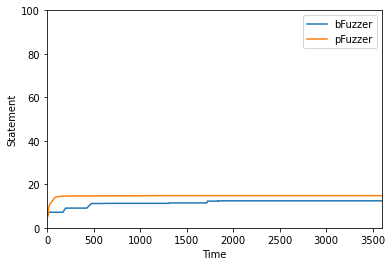

In [204]:
plt.plot(cjson_time, cjson_line, label='bFuzzer')
plt.plot(pcjson_time, pcjson_line, label='pFuzzer')
plt.ylabel('Statement')
plt.xlabel('Time')
#plt.title('CJSON Cumulative Statement Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
zoom(plt, 'cjson-s')

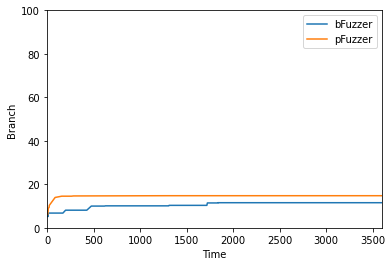

In [205]:
plt.plot(cjson_time, cjson_branch, label='bFuzzer')
plt.plot(pcjson_time, pcjson_branch, label='pFuzzer')
plt.ylabel('Branch')
plt.xlabel('Time')
#plt.title('CJSON Cumulative Branch Coverage')
plt.axis([0, 3600, 0, 100]) 
plt.legend()
zoom(plt, 'cjson-b')